# MIDS UC Berkeley - Machine Learning at Scale
## DATSCIW261 ASSIGNMENT #2  

[James Gray](https://github.com/jamesgray007)   
jamesgray@ischool.berkeley.edu   
Time of Initial Submission: 11:30 PM US Central, Saturday, May 28, 2016  
Time of **Resubmission**:  
W261-1, Spring 2016  
Week 2 Homework

## References for this Assignment

* [Writing an Hadoop MapReduce Program in Python](http://www.michael-noll.com/tutorials/writing-an-hadoop-mapreduce-program-in-python/)
* [Hadoop Streaming](http://hadoop.apache.org/docs/current/hadoop-streaming/HadoopStreaming.html)


## HW 2.0 - Hadoop & MapReduce

**_1. What is a race condition in the context of parallel computation? Give an example._**

A race condition can exist when multiple parallel computing processes are accessing a shared variable without synchronization and there is uncertainty on the value of the variable given that its unpredictable which process will operate on the shared variable before the other or perhaps at the same time. The final value can be very different. An example of a race condition is as follows. Let's say we have two threads (A and B) that are computing the score of a game and an update is required to increment the score by 1.  We could have the following scenarios that produce different results:

Calculation for updating the game score:  score = score + 1

**Scenario 1**: If both processes accessed the "score" shared variable and increment the value by 1 then the new value would be score = score + 1

**Scenario 2**: If process A reads the variable and updates score and then process B reads score and update the variable by 1 then the final value would be score = score + 2.

The key point here is the race condition produces unpredictable results unless you can use a sychronization technique such as a mutex or barrier pattern to control which process has access to the variable at single point in time.


**_2. What is MapReduce?_**

![mr](img/mr.png)

MapReduce is a programming model for large scale data processing. Fundamentally it's based on a shared nothing architecture to achieve high performance parallel computation.  The programming model breaks down processing into "map" tasks and "reduce" tasks. Data is split across the map tasks that run in parallel where it is processed using specific logic in the mapper. Each map task emits data as key-value pairs where keys can be combined in partitioner before being passed onto the reducer tasks. These key-value pairs are then sorted by the framework so that all keys are processed by the next step called the reduce task. The reducer then uses the keys to run specific logic on the value part of the key-value pair.


**_3. How does it differ from Hadoop?_**

Hadoop is the implementation of the MapReduce programming model and also includes a data storage layer called the Hadoop Distributed File System (HDFS). It essentially takes care of all of the coordination, synchronization, storage and network communication to execute the MapReduce jobs. The framework handles many of the challenges of parallel computation including concurrency, communication synchronization, access to shared data structures, deadlocks
At a minimum the programmer must specific the map and reduce tasks and then the framework manages the distributed computation.  The framework determines how to divide the tasks across the nodes of the cluster and moves the computation to the data stored in HDFS.

**_4. Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running._**

Functional Programming is the paradigm that underpins MapReduce and Hadoop.  Higher-order-functions(functions that accept functions as inputs) is the primary concept of functional programming and this is applied to the map and reduce tasks.  The map accepts user defined functions and operates on a set of data. The reduce operates on the result of the map and this is somewhat equivalent to the "fold" function in functional programming.






## HW2.1. Sort in Hadoop MapReduce

1. Given as input: Records of the form <integer, “NA”>, where integer is any integer, and “NA” is just the empty string. Output: sorted key value pairs of the form <integer, “NA”> in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.     

2. Write code to generate N random records of the form <integer, “NA”>. Let N = 10,000.  

3. Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers  

In [416]:
# setup variables and libraries
N = 10000
DATA_FILE = "integers.txt"
import numpy as np

# random.randit will produce an array of random integers (http://bit.ly/1R9QelC)
integers = np.random.randint(1000000, size=N) # produce 10K random integers between 0 - 1,000,000

# open file to hold the random integer records
#with open("integers.txt", 'w') as f:
with open(DATA_FILE, 'w') as f:    
    # loop through the integer array and generate output records to file
    for integer in integers:
        f.write(str(integer) + ',NA' + '\n')

### HW2.1 Mapper

In [417]:
%%writefile mapper.py
#!/usr/bin/env python
import sys

# read each line of the integer text file 
for line in sys.stdin:
    # remove leading and trailing chars for each line and create key-value pair
    print ("%s" % (line.strip()))

Overwriting mapper.py


### HW2.1 Reducer

Note that the Hadoop MR framework sorts the keys before it arrives at the reducer

In [418]:
%%writefile reducer.py
#!/usr/bin/env python
import sys

for line in sys.stdin:
    print ("%s" % (line.strip()))

Overwriting reducer.py


In [419]:
# set file priveleges to execute script
!chmod a+x reducer.py
!chmod a+x mapper.py

### Load Integers.txt file into HDFS

In [456]:
# create a directory for hw02#
#!hdfs dfs -mkdir -p /user/graymatter

#!hadoop version

#add integer.txt file to HDFS
#!hdfs dfs -put "integers.txt" /user/graymatter/

#confirm file added to HDFS
!hdfs dfs -ls /user/graymatter/integers.txt

16/05/25 09:34:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
-rw-r--r--   1 jamesgray supergroup      98879 2016-05-20 21:04 /user/graymatter/integers.txt


### Execute Hadoop Streaming Job

Basic structure of a Hadoop Streaming job http://hadoop.apache.org/docs/current/hadoop-streaming/HadoopStreaming.html#Hadoop_Streaming

The KeyFieldBasedComparator enables the mapper output to be sorted before it goes to the reducer(s). Sorting options are provided by the mapred.text.key.comparator.options (-n is a numerical sort and -r is a reserve sort)


In [420]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw21-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options=-nr \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/graymatter/integers.txt -output /user/graymatter/hw21-output

16/05/24 23:07:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 23:07:33 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw21-output
16/05/24 23:07:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 23:07:34 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/24 23:07:34 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/24 23:07:34 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/24 23:07:35 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/24 23:07:35 INFO mapreduce.JobSubmitter: number of splits:1
16/05/24 23:07:35 INFO Configuration.

### Display Reducer Output

[Hadoop filesystem commands](http://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html#cat)

* **head** -10 displays the first ten lines of a text file
* **tail** -10 displays the last ten lines of a text file
* https://linuxfrombeginning.wordpress.com/2008/09/19/linux/

In [25]:
#!hdfs dfs -cat /user/graymatter/hw21-output/* | head -10

print("10 largest numbers in integers.txt. file")
!hadoop fs -cat /user/graymatter/hw21-output/* | head -10

print("10 smallest numbers in the integers.txt file")
!hadoop fs -cat /user/graymatter/hw21-output/* | tail -10

10 largest numbers in integers.txt. file
16/05/21 15:12:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
999894,NA	
999855,NA	
999761,NA	
999694,NA	
999641,NA	
999477,NA	
999344,NA	
999246,NA	
999083,NA	
999027,NA	
cat: Unable to write to output stream.
10 smallest numbers in the integers.txt file
16/05/21 15:12:14 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
1308,NA	
1282,NA	
1169,NA	
1039,NA	
972,NA	
936,NA	
795,NA	
546,NA	
304,NA	
85,NA	


## HW2.2.  WORDCOUNT

Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimited token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

CROSSCHECK: >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
       8    

#NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!


### HW2.2 Mapper

The mapper must read each line, parse the line into tokens and output a key-value pair of "word,1" so that reducer(s) can sum each word key.  The [Michael Noll](http://www.michael-noll.com/tutorials/writing-an-hadoop-mapreduce-program-in-python/) articles provides a nice working example and was used as a reference to develop my code.  The only slight modification here is that we are filtering the text for the specific word "assistance". Therefore we will only emit a key-value pair when the word is "assistance".

All messages are collated to a tab-delimited format:  
ID \t SPAM \t SUBJECT \t CONTENT \n  

where:  
ID = string; unique message identifier  
SPAM = binary; with 1 indicating a spam message  
SUBJECT = string; title of the message  
CONTENT = string; content of the message  

In [58]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: James Gray
## Description: mapper code for HW2.2

import sys
import re
findword = "assistance"
WORD_RE = re.compile(r"[\w']+")

# input comes from STDNIN and is specified in the Hadoop Streaming job
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # create a next text string of the subject and body similar to HW1
    text = ""
    # the string.split returns a list of words in the string
    # the string.join command concatenates a list of words
    subject_body = text.join(line.split('\t')[-2:]) # filter to the last two words in the list (subject, content)
    
    # split the subject and body into tokens
    #word_tokens = subject_body.split() # split returns list of word tokens
    
    # iterate through words
    for word in WORD_RE.findall(subject_body):
        if word == findword:
            # create key-value pair for each word and send to STDOUT
            print('%s\t%s') % (word, 1)
    

Overwriting mapper.py


### HW2.2 Reducer

In [428]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: James Gray
## Description: reducers code for HW2.2

from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print '%s\t%s' % (current_word, current_count)

Overwriting reducer.py


### Load Enron Email corpus into HDFS

In [152]:
# add enronemail_1h.txt file to HDFS

#!hadoop fs -rm -r /user/graymatter/enronemail_1h.txt

!hdfs dfs -put "enronemail_1h.txt" /user/graymatter/

# check to confirm enron email was sent to HDFS
!hadoop fs -ls /user/graymatter/

16/05/23 18:10:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/23 18:10:55 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 7 items
-rw-r--r--   1 jamesgray supergroup     202254 2016-05-23 18:10 /user/graymatter/enronemail_1h.txt
drwxr-xr-x   - jamesgray supergroup          0 2016-05-21 14:50 /user/graymatter/hw21-output
drwxr-xr-x   - jamesgray supergroup          0 2016-05-21 14:46 /user/graymatter/hw21-output.txt
drwxr-xr-x   - jamesgray supergroup          0 2016-05-21 17:22 /user/graymatter/hw22-output
drwxr-xr-x   - jamesgray supergroup          0 2016-05-21 17:27 /user/graymatter/hw221-output
drwxr-xr-x   - jamesgray supergroup          0 2016-05-23 18:06 /user/graymatter/hw23_job1-output
-rw-r--r--   1 jamesgray supergroup      98879 2016-05-20 21:04 /user/graymatter/integers.txt


### Execute Hadoop Streaming Job

In [60]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw22-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw22-output

16/05/21 17:22:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/21 17:22:39 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw22-output
16/05/21 17:22:40 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/21 17:22:41 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/21 17:22:41 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/21 17:22:41 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/21 17:22:41 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/21 17:22:41 INFO mapreduce.JobSubmitter: number of splits:1
16/05/21 17:22:41 INFO mapreduce.JobS

In [61]:
#!hadoop fs -cat /user/graymatter/*

#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw22-output/* 

16/05/21 17:22:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
assistance	10


## HW2.2.1  

Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)


### HW2.2.1 Mapper #1 (Emit KV Pair -> (Word, 1) )

In [442]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: James Gray
## Description: mapper code for HW2.2.1

import sys
import re

WORD_RE = re.compile(r"[\w']+")

# input comes from STDNIN and is specified in the Hadoop Streaming job
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # create a next text string of the subject and body similar to HW1
    text = ""
    # the string.split returns a list of words in the string
    # the string.join command concatenates a list of words
    subject_body = text.join(line.split('\t')[-2:]) # filter to the last two words in the list (subject, content)
    
    # split the subject and body into tokens
    #word_tokens = subject_body.split() # split returns list of word tokens
    # interate through words
    for word in WORD_RE.findall(subject_body):
        # create key-value pair for each word and send to STDOUT
        print('%s\t%s') % (word, 1)

Overwriting mapper.py


### HW2.2.1 Reducer #1 (Aggregate Word Count)

In [448]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: James Gray
## Description: reducers code for HW2.2

from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print '%s\t%s' % (current_word, current_count)

Overwriting reducer.py


### HW2.2.1 Mapper #2 (Reverse the KV Pair to enable sort by Key as Number)

In [449]:
%%writefile mapper2.py
#!/usr/bin/python

#HW 2.2.1 - Mapper Function Code
import sys
for line in sys.stdin:
    line=line.strip() #strip whitespace, just to be safe
    cols=line.split('\t') #parse remaining line
    print cols[1]+'\t'+cols[0] #reverse key-value from previous job

Overwriting mapper2.py


### HW2.2.1 Reducer #2 (Deliver Mapper Output Directly to HDFS)

In [450]:
%%writefile reducer2.py
#!/usr/bin/python

#HW 2.2.1 - Reducer Function Code
import sys
for line in sys.stdin:
    print "%s" % (line.strip()) 

Overwriting reducer2.py


### HW2.2.1 Run locally on Unix

In [458]:
!chmod +x ./mapper2.py ./reducer2.py
!cat enronemail_1h.txt | ./mapper.py |sort -k1,1| ./reducer.py | ./mapper2.py | sort -nr | ./reducer2.py > hw221_test.txt
!cat hw221_test.txt | head -10 
!rm hw221_test.txt

1230	the
952	to
657	and
557	of
539	a
426	you
410	in
387	your
382	ect
365	for


### HW2.2.1 Run Map-Reduce Job #1

In [439]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw221_job1-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw221_job1-output


16/05/24 23:36:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 23:36:56 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw221_job1-output
16/05/24 23:36:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 23:36:58 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/24 23:36:58 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/24 23:36:58 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/24 23:36:59 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/24 23:36:59 INFO mapreduce.JobSubmitter: number of splits:1
16/05/24 23:36:59 INFO mapreduc

In [446]:
!hadoop fs -cat /user/graymatter/hw221_job1-output/*

16/05/24 23:46:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
'	3
'bcli	1
'benewm	1
'bjeffrie	1
'blong	1
'bredd	1
'celias	1
'cenochs	1
'chuck	1
'colliw	1
'connie	1
'ctise	1
'davidyi	1
'dfelsinger	1
'dkohler	1
'dmao	1
'don	1
'doug	1
'dronn	1
'five	1
'gary	1
'glen	1
'hal	1
'hans	1
'harry_wijsman	1
'hoferc	1
'iccenergy	1
'ilydiatt	1
'jeff	1
'jlopes	1
'jnexon	1
'john	1
'jones	1
'jonesg	1
'jshorter	1
'kelly	1
'kenny	1
'larry	1
'llittle	1
'mcclankg	1
'mcosta	1
'michael_huse	1
'mmce	1
'mperkins	1
'msessa	1
'njwa	1
'pete	1
'prez	1
'priscilla	1
'pwarden	1
'randall	1
'randy	1
'reason	1
'repling	1
'richard	1
'richarddaniel	1
'rsbaker	1
'ryanmcgeachie	1
'sallen	1
'scampbell	1
'sdba	1
'singleton	1
'smithc	1
'stefkatz	1
'steve	1
'swbe	1
'swidner	1
'taylor	1
'taylorja	1
'tgary	1
'travis	1
'underga	1
'william	1
'wisew	1
0	7
00	31
000	52
001	2
0011	1
00450	1
01	24
012	4
02	19
028	1
0281	1
03	3
036474336	1
04	7
048	1
0

### HW2.2.1 Run Map-Reduce Job #2

In [452]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw221_job2-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D  mapred.text.key.comparator.options=-nr \
-files mapper2.py,reducer2.py -mapper mapper2.py -reducer reducer2.py \
-input /user/graymatter/hw221_job1-output -output /user/graymatter/hw221_job2-output


16/05/24 23:52:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/graymatter/hw221_job2-output': No such file or directory
16/05/24 23:52:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 23:52:23 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/24 23:52:23 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/24 23:52:23 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/24 23:52:24 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/24 23:52:24 INFO mapreduce.JobSubmitter: number of splits:1
16/05/24 23:52:24 INFO Configuration.deprecation: mapred.text.key.comparator.options is deprecated. Instead, use mapreduce.partition.keycompara

In [454]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw221_job2-output/* | head -10

16/05/24 23:52:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
1230	the
952	to
657	and
557	of
539	a
426	you
410	in
387	your
382	ect
365	for
cat: Unable to write to output stream.


## HW2.3. Multinomial NAIVE BAYES with NO Smoothing

Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that
   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

   the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 

E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. 

Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilities that are zero! They will need special attention. **Count up how many times you need to process a zero probabilty for each class and report**. 

Report the performance of your learnt classifier in terms of misclassification error rate of your multinomial Naive Bayes Classifier. 

Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 

Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let DF represent the evaluation set in the following:
Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”



### Breaking down the problem

Here we just break down the components we need to train a MNB model and classify documents.  Figure 13.2 (page 261) from "An Introduction to Information Retrieval" provides an algorithm to code this up. 

![mnb](img/mnb_algo.png)

Training components we need to calculate:

1. V = vocabulary -> all words in the document corpus
2. N = the number of documents in the corpus
3. Nc = the number of documents in each class (spam and ham)
4. Prior of each class = Nc/N
5. Text string of all docs in class
7. Count of unique words
8. Count of words for each class
9. Conditional probabilities of each word

![diagram](img/diagram2.png)

### HW2.3 Mapper -> Emit words, classes

This mapper will process each document in the corpus to extract the unique words in each document (to build vocabulary) and attach the spam/ham flag. This will enable a reducer to build/calculate components above. Since the mapper will process each document, its suitable to calculate the number of documents of each class (#3).  The mapper will produce a key-value structure as follows:

word, "spam flag" \t "number of word occurrences"

All messages are collated to a tab-delimited format:  
ID \t SPAM \t SUBJECT \t CONTENT \n  

where:  
ID = string; unique message identifier  
SPAM = binary; with 1 indicating a spam message  
SUBJECT = string; title of the message  
CONTENT = string; content of the message  


In [478]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: James Gray
## Description: mapper code for HW2.3

import sys
import re
WORD_RE = re.compile(r"[\w']+")

# counters for words and documents - this will be used by reducer to calculate priors
ham_word_count =0
spam_word_count = 0
ham_doc_count = 0
spam_doc_count = 0

# input comes from STDNIN and is specified in the Hadoop Streaming job
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # create tokens for each line
    cols = line.split('\t')
    # create a next text string of the subject and body similar to HW1
    text = ""
    spam = cols[1] # pull out spam/ham flag
    # the string.split returns a list of words in the string and string.join concatenates a list of words
    subject_body = text.join(line.split('\t')[-2:]) # filter to the last two words in the list (subject, content)
    words_in_doc = WORD_RE.findall(subject_body) # returns list of word tokens
    #unique_words_doc = set(words_in_doc) # set returns non-duplicate words
    
    # Count the documents of each class (this will be used by Reducer to calculate priors)
    #if spam == 0:
    #    ham_doc_count+=1
    #else:
    #    spam_doc_count+=1
    
    # iterate through words to create kv pairs for each word
    for word in words_in_doc:
        # count how many times this word occurred in document 
        # word_count = words_in_doc.count(word) 
        
        # create key-value pair for each word and send to STDOUT 
        # key-value structure:  word, spam/ham class \t word # occurences
        #print('%s\t%s\t%s') % (word, spam, word_count)
        print('%s\t%s\t%s') % (word, spam, 1)
        
    # emit key-value pair for document and spam/ham class - this will be reducer to calculate priors
    print('%s\t%s\t%s') % ('DOC.CLASS', spam, 1)


Overwriting mapper.py


### HW2.3 Reducer (Calculate Conditional Probabilities and Priors)

In [479]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: James Gray
## Description: reducer code for HW2.3

from __future__ import division
import sys
from math import log

# counters for words and documents - this will be used by reducer to calculate priors
ham_word_count =0
spam_word_count = 0
ham_doc_count = 0
spam_doc_count = 0

current_word = None
word = None
current_spam_count = 0
current_ham_count=0
current_count=0

prior_ham=0
prior_spam=0

words={} # dictionary to hold conditional probabilities

# process input from STDIN from mapper (word, spam_flag) OR (DOC.CLASS, spam_flag)
for line in sys.stdin:
    # remove leading and trailing whitespaces
    line = line.strip()
    # parse the mapper output into key, value
    #word, spam = line.split('\t')  
    cols = line.split('\t')
    word = cols[0]
    spam = cols[1]
    count = cols[2]
    
    # convert value strings into integers
    try: 
        spam = int(spam)
        count = int(count)
    except ValueError:
        # value failed casting so continue on
        continue
    
    # check to see if key-value is at the document level to calculate # of documents for each class     
    if word =='DOC.CLASS':
        if spam==0:
            # increment count of ham docs
            ham_doc_count+=1
        else:
            # increment count of spam docs
            spam_doc_count+=1
    
    # count number of word occurences based on Michael G. Noll algorithm
    if current_word == word:
        current_count+=count
        if spam==1:
            current_spam_count+=1
            spam_word_count+=1 # total words in spam documents
        elif spam==0:
            current_ham_count+=1
            ham_word_count+=1 # total words in ham documents
    else:
        if current_word:
            # write result to STDOUT
            # this will provide the occurences of the word in spam and ham classes
            #print(current_word+'\t'+str(current_spam_count)+'\t'+str(current_ham_count))
            # add word to dictionary
            words[current_word] = {'spam_count':current_spam_count, 'ham_count':current_ham_count}
    
        # set the current word
        current_word = word
        current_count=count
        if spam==1:
            current_spam_count=1
            current_ham_count=0
            spam_word_count+=1 # total words in spam documents
        elif spam==0:
            current_ham_count=1
            current_spam_count=0
            ham_word_count+=1 # total words in ham documents
            
# do not forget to output the last word if needed!
if current_word == word:
    # emit word and # of occurences in spam \t # of occurences in ham
    #print(current_word+'\t'+ str(current_spam_count)+'\t'+str(current_ham_count))
    # add word to dictionary
    words[current_word] = {'spam_count':current_spam_count, 'ham_count':current_ham_count}

# calculate conditional probabilities for each word without smoothing
for k,word in words.iteritems():
    # calculate and add to dictionary
    word['prob_spam'] = (word['spam_count']/(spam_word_count))
    word['prob_ham'] = (word['ham_count']/(ham_word_count))
    # emit key-value pair for conditional probs
    #print(k + str(word['prob_spam'] + str(word['prob_ham']))
    print k + '\t' + str(word['prob_spam']) + '\t' + str(word['prob_ham'])
    
# calculate and emit priors
prior_spam = spam_doc_count/(spam_doc_count + ham_doc_count)
prior_ham = ham_doc_count/(spam_doc_count + ham_doc_count)
print('%s\t%s\t%s') % ('SPAMHAM.PRIOR', prior_spam, prior_ham)


Overwriting reducer.py


### HW2.3 Mapper #2

In [497]:
%%writefile mapper2.py
#!/usr/bin/python
## mapper2.py
## Author: James Gray
## Description: 2nd mapper code for HW2.3

from __future__ import division
import sys
from math import log,exp
import re
import subprocess

# variables to calculate conditional probabilities
prob={} 
spam_email_count=0 # number of emails marked as spam
spam_word_count=0 # number of total (not unique) words in spam emails
ham_word_count=0 # number of total (not unique) words in ham emails
v_count = 0 # total number of words in the corpus vocabulary
doc_count = 0 # total number of documents in corpus
zero_prob_spam = 0
zero_prob_ham = 0

prior_spam = 0.0
prior_ham = 0.0

p_spam = 0.0
p_ham = 0.0

zero_prob_count = 0 # count how many times there were words not in the dictionary -> 0 probability
misclassify_count = 0 # count how many times the classifier to not classify to true class

WORD_RE = re.compile(r"[\w']+")

# load reducer output that contains 2 key-value pair types: 
# for word counts:  word \t #_of_occurences_in_spam \t #_of_occurences_in_ham
# for prior calcs:  SPAMHAM.PRIOR \t prior_spam \t prior_ham

# read mapper #1 output directly from HDFS
cat = subprocess.Popen(["hadoop", "fs", "-cat", "/user/graymatter/hw23_job1-output/part-00000"], stdout=subprocess.PIPE)
for line in cat.stdout:
    # remove leading and trailing whitespace
    line = line.strip()
    cols = line.split('\t') # parse the line to pull out key & values 
        
    # check to see if key-value pair is for priors
    if cols[0]=="SPAMHAM.PRIOR":
        prior_spam = float(cols[1])
        prior_ham = float(cols[2])
        
    # if not priors then its conditional probs for each word
    else:   
        # added Tuesday -> changed reducer #1 to calc conditional probs; rebuild dict here
        word = cols[0]
        spam_cond_prob = float(cols[1])
        ham_cond_prob = float(cols[2])
        # populate dict
        prob[word] = {'prob_spam':spam_cond_prob, 'prob_ham':ham_cond_prob}
        
# calculate the vocabulary size
v_count = len(prob)

# iterate through each word and calculate the conditional probability without smoothing
#for k,word in words.iteritems():
    # calculate and add to dictionary
#    word['prob_spam'] = (word['spam_count']/(spam_word_count))
#    word['prob_ham'] = (word['ham_count']/(ham_word_count))
    
# we now have a dictionary of each word and their conditional probabilities for spam / ham
# we can now make predictions for each document in the corpus

# read in the Enron email corpus
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    cols = line.split('\t') # parse the line to pull out key & values
    true_class = int(cols[1])
    email_id = cols[0]
    #parse the subject and body fields from the line, and combine into one string
    subject_and_body=" ".join(cols[-2:])
    words_in_doc=re.findall(WORD_RE,subject_and_body) #create list of unique words in doc
    
    # calculate the log prob for priors
    p_spam=log(prior_spam)
    p_ham=log(prior_ham)
    
    # iterate through each word of the email subject and header
    for word in words_in_doc:
        # check to see if word has zero prob for the class and if so increment the counter
        if prob[word]['prob_spam']==0:
            zero_prob_spam+=1
        elif prob[word]['prob_ham']==0:
            zero_prob_ham+=1
        else:
            p_spam+=log(float(prob[word]['prob_spam'])) # adds conditional probs to prior prob brought in above
            p_ham+=log(float(prob[word]['prob_ham'])) 
            
    # make the prediction
    if p_spam > p_ham:
        spam_pred = 1
    else:
        spam_pred = 0
    
    with open("histogram.tsv", "a") as hist_file:
        hist_file.write('%f\t%f\n' % (p_spam, p_ham))
        
    # calculate the accuracy
    if spam_pred != true_class:
        misclassify_count+=1
    
    # send output to reducer
    print(email_id + '\t' + str(true_class) + '\t' + str(spam_pred))
    
           
# send number of zero probabilities to reducer
print("ZERO.PROB" + '\t' + str(zero_prob_spam) + '\t' + str(zero_prob_ham))           
        

Overwriting mapper2.py


### HW2.3 Reducer #2 (Calculate Metrics)

In [603]:
%%writefile reducer2.py
#!/usr/bin/python
## reducer2.py
## Author: James Gray
## Description: reducer #2 code for HW2.3

from __future__ import division
misclassify_count = 0 # count how many times the classifier to not classify to true class
email_count = 0
misclass_rate = 0.0

import sys
for line in sys.stdin:
    # remove leading and trailing whitespaces
    line = line.strip()
    # parse the mapper output into key, value
    cols = line.split('\t')  
    
    # check to see if key-value pair is for zero probabilities
    if cols[0] =='ZERO.PROB':
        print("zero_prob_spam \t" + str(cols[1]))
        print("zero_prob_ham \t" + str(cols[2]))
    else: # evaluate email true class and predicted class
        true_class = int(cols[1])
        pred_class = int(cols[2])
              
        email_count+=1 # calculate total document for misclassification rate
    
        # evaluate if true and predicted class are the same
        if true_class != pred_class:
            misclassify_count+=1
    
misclass_rate = float(misclassify_count/email_count)

print("misclass_rate \t" + str(misclass_rate))


Overwriting reducer2.py


### HW2.3 Testing with UNIX script before MR job

In [482]:
# set file priveleges to execute script
!chmod a+x reducer.py
!chmod a+x mapper.py
!chmod a+x reducer2.py
!chmod a+x mapper2.py

In [492]:
#!cat enronemail_1h.txt | ./mapper.py

# delete any existing files in the output directory
#!hadoop fs -rm -r /user/graymatter/hw23_job1-output

# run first mapper and reducer
!cat enronemail_1h.txt | ./mapper.py | sort | ./reducer.py > part-00000

#!cat enronemail_1h.txt | ./mapper.py  > words.txt

# run second mapper and reducer
!cat enronemail_1h.txt | ./mapper2.py | ./reducer2.py


16/05/25 11:38:19 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
zero_prob_spam 	4961
zero_prob_ham 	5623
misclass_rate 	0


### HW2.3 Execute MR Jobs

In [349]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw23_job1-output

# Run first MR job
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw23_job1-output


16/05/24 20:41:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 20:41:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw23_job1-output
16/05/24 20:41:25 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 20:41:26 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/24 20:41:26 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/24 20:41:26 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/24 20:41:27 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/24 20:41:27 INFO mapreduce.JobSubmitter: number of splits:1
16/05/24 20:41:27 INFO mapreduce

In [331]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw23_job1-output/* 

16/05/24 20:33:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
yellow	5.42534722222e-05	0.0
barraged	5.42534722222e-05	0.0
prefix	5.42534722222e-05	0.0
railing	5.42534722222e-05	0.0
increase	0.000325520833333	0.000420256356377
granting	5.42534722222e-05	0.0
electricity	0.0	7.00427260629e-05
originality	5.42534722222e-05	0.0
homemakers	5.42534722222e-05	0.0
hormone	0.000108506944444	0.0
regional	0.0	0.000770469986692
screaming	5.42534722222e-05	0.0
four	0.000271267361111	0.000210128178189
internally	0.0	0.000140085452126
prize	5.42534722222e-05	0.0
customizable	5.42534722222e-05	0.0
wednesday	0.0	0.000420256356377
cyberopps	0.000108506944444	0.0
charter	0.0	0.000140085452126
tired	0.000108506944444	0.0
miller	0.0	7.00427260629e-05
bacon	5.42534722222e-05	0.0
tires	0.000162760416667	0.0
second	0.000162760416667	7.00427260629e-05
errors	0.000271267361111	7.00427260629e-05
thunder	5.42534722222e-05	0.0
day

In [350]:
# Run 2nd MR Job

!hadoop fs -rm -r /user/graymatter/hw23_job2-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper2.py,reducer2.py -mapper mapper2.py -reducer reducer2.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw23_job2-output



16/05/24 20:41:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 20:41:41 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw23_job2-output
16/05/24 20:41:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 20:41:43 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/24 20:41:43 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/24 20:41:43 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/24 20:41:44 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/24 20:41:44 INFO mapreduce.JobSubmitter: number of splits:1
16/05/24 20:41:44 INFO mapreduce

In [459]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw23_job2-output/* 

16/05/25 10:02:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
zero_prob_spam 	4961
zero_prob_ham 	5623
misclass_rate 	0


### HW2.3 Final Output Summary

* Misclassification Rate = 0 
* Zero conditional probability for Spam documents = 5623
* Zero conditional probability for Ham documents = 4961

### HW2.3 Histogram of Posterior Log Probabilties for Each Class - P(Class | Doc)

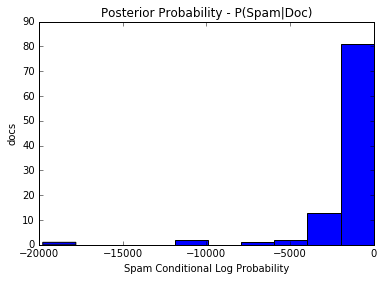

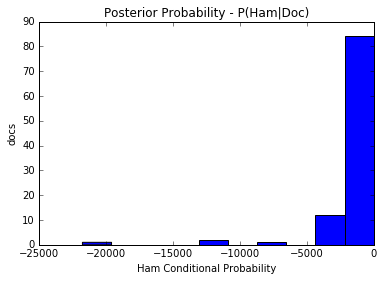

In [473]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_2_3():
    
    data=pd.read_csv("histogram.tsv", sep='\t', header=None)
    columns=['p_spam','p_ham']
    data.columns=columns
     
    plt.hist(data['p_spam'])
    plt.xlabel("Spam Conditional Log Probability")
    plt.ylabel("docs")
    plt.title("Posterior Probability - P(Spam|Doc)")
    plt.show()

    plt.hist(data['p_ham'])
    plt.xlabel("Ham Conditional Probability")
    plt.ylabel("docs")
    plt.title("Posterior Probability - P(Ham|Doc)")
    plt.show()

run_2_3()
    

## HW2.4

Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassification error rates for 2.3 versus 2.4 and explain the differences.

For a quick reference on the construction of the Multinomial NAIVE BAYES classifier that you will code,
please consult the "Document Classification" section of the following wikipedia page:

https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification

OR the original paper by the curators of the Enron email data:

http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf


### HW2.4 Reducer (HW2.3 Reducer #1 Modified )

In [503]:
%%writefile reducer24.py
#!/usr/bin/python
## reducer.py
## Author: James Gray
## Description: reducer code for HW2.3

from __future__ import division
import sys
from math import log

# counters for words and documents - this will be used by reducer to calculate priors
ham_word_count =0
spam_word_count = 0
ham_doc_count = 0
spam_doc_count = 0

current_word = None
word = None
current_spam_count = 0
current_ham_count=0
current_count=0

prior_ham=0
prior_spam=0

words={} # dictionary to hold conditional probabilities

# process input from STDIN from mapper (word, spam_flag) OR (DOC.CLASS, spam_flag)
for line in sys.stdin:
    # remove leading and trailing whitespaces
    line = line.strip()
    # parse the mapper output into key, value
    cols = line.split('\t')
    word = cols[0]
    spam = cols[1]
    count = cols[2]
    
    # convert value strings into integers
    try: 
        spam = int(spam)
        count = int(count)
    except ValueError:
        # value failed casting so continue on
        continue
    
    # check to see if key-value is at the document level to calculate # of documents for each class     
    if word =='DOC.CLASS':
        if spam==0:
            # increment count of ham docs
            ham_doc_count+=1
        else:
            # increment count of spam docs
            spam_doc_count+=1
    
    # count number of word occurences based on Michael G. Noll algorithm
    if current_word == word:
        current_count+=count
        if spam==1:
            current_spam_count+=1
            spam_word_count+=1 # total words in spam documents
        elif spam==0:
            current_ham_count+=1
            ham_word_count+=1 # total words in ham documents
    else:
        if current_word:
            # write result to STDOUT
            # this will provide the occurences of the word in spam and ham classes
            #print(current_word+'\t'+str(current_spam_count)+'\t'+str(current_ham_count))
            # add word to dictionary
            words[current_word] = {'spam_count':current_spam_count, 'ham_count':current_ham_count}
    
        # set the current word
        current_word = word
        current_count= count
        if spam==1:
            current_spam_count=1
            current_ham_count=0
            spam_word_count+=1 # total words in spam documents
        elif spam==0:
            current_ham_count=1
            current_spam_count=0
            ham_word_count+=1 # total words in ham documents
            
# do not forget to output the last word if needed!
if current_word == word:
    # emit word and # of occurences in spam \t # of occurences in ham
    #print(current_word+'\t'+ str(current_spam_count)+'\t'+str(current_ham_count))
    # add word to dictionary
    words[current_word] = {'spam_count':current_spam_count, 'ham_count':current_ham_count}

vocab_count = len(words)

# calculate conditional probabilities for each word with smoothing
for k,word in words.iteritems():
    # calculate and add to dictionary
    word['prob_spam'] = (word['spam_count']+1)/(spam_word_count+vocab_count)
    word['prob_ham'] = (word['ham_count']+1)/(ham_word_count+vocab_count)
    # emit key-value pair for conditional probs
    #print(k + str(word['prob_spam'] + str(word['prob_ham']))
    print k + '\t' + str(word['prob_spam']) + '\t' + str(word['prob_ham'])
    
# calculate and emit priors
prior_spam = spam_doc_count/(spam_doc_count + ham_doc_count)
prior_ham = ham_doc_count/(spam_doc_count + ham_doc_count)
print('%s\t%s\t%s') % ('SPAMHAM.PRIOR', prior_spam, prior_ham)


Overwriting reducer24.py


In [504]:
%%writefile mapper24.py
#!/usr/bin/python
## mapper2.py
## Author: James Gray
## Description: 2nd mapper code for HW2.3

from __future__ import division
import sys
from math import log,exp
import re
import subprocess

# variables to calculate conditional probabilities
prob={} 
spam_email_count=0 # number of emails marked as spam
spam_word_count=0 # number of total (not unique) words in spam emails
ham_word_count=0 # number of total (not unique) words in ham emails
v_count = 0 # total number of words in the corpus vocabulary
doc_count = 0 # total number of documents in corpus
zero_prob_spam = 0
zero_prob_ham = 0

prior_spam = 0.0
prior_ham = 0.0

p_spam = 0.0
p_ham = 0.0

zero_prob_count = 0 # count how many times there were words not in the dictionary -> 0 probability
misclassify_count = 0 # count how many times the classifier to not classify to true class

WORD_RE = re.compile(r"[\w']+")

# load reducer output that contains 2 key-value pair types: 
# for word counts:  word \t #_of_occurences_in_spam \t #_of_occurences_in_ham
# for prior calcs:  SPAMHAM.PRIOR \t prior_spam \t prior_ham

# read mapper #1 output directly from HDFS
cat = subprocess.Popen(["hadoop", "fs", "-cat", "/user/graymatter/hw24_job1-output/part-00000"], stdout=subprocess.PIPE)
for line in cat.stdout:
    # remove leading and trailing whitespace
    line = line.strip()
    cols = line.split('\t') # parse the line to pull out key & values 
        
    # check to see if key-value pair is for priors
    if cols[0]=="SPAMHAM.PRIOR":
        prior_spam = float(cols[1])
        prior_ham = float(cols[2])
        
    # if not priors then its conditional probs for each word
    else:   
        # added Tuesday -> changed reducer #1 to calc conditional probs; rebuild dict here
        word = cols[0]
        spam_cond_prob = float(cols[1])
        ham_cond_prob = float(cols[2])
        # populate dict
        prob[word] = {'prob_spam':spam_cond_prob, 'prob_ham':ham_cond_prob}
        
# calculate the vocabulary size
v_count = len(prob)

# iterate through each word and calculate the conditional probability without smoothing
#for k,word in words.iteritems():
    # calculate and add to dictionary
#    word['prob_spam'] = (word['spam_count']/(spam_word_count))
#    word['prob_ham'] = (word['ham_count']/(ham_word_count))
    
# we now have a dictionary of each word and their conditional probabilities for spam / ham
# we can now make predictions for each document in the corpus

# read in the Enron email corpus
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    cols = line.split('\t') # parse the line to pull out key & values
    true_class = int(cols[1])
    email_id = cols[0]
    #parse the subject and body fields from the line, and combine into one string
    subject_and_body=" ".join(cols[-2:])
    words_in_doc=re.findall(WORD_RE,subject_and_body) #create list of unique words in doc
    
    # calculate the log prob for priors
    p_spam=log(prior_spam)
    p_ham=log(prior_ham)
    
    # iterate through each word of the email subject and header
    for word in words_in_doc:
        # check to see if word has zero prob for the class and if so increment the counter
        if prob[word]['prob_spam']==0:
            zero_prob_spam+=1
        elif prob[word]['prob_ham']==0:
            zero_prob_ham+=1
        else:
            p_spam+=log(float(prob[word]['prob_spam'])) # adds conditional probs to prior prob brought in above
            p_ham+=log(float(prob[word]['prob_ham'])) 
            
    # make the prediction
    if p_spam > p_ham:
        spam_pred = 1
    else:
        spam_pred = 0
    
    with open("histogram24.tsv", "a") as hist_file:
        hist_file.write('%f\t%f\n' % (p_spam, p_ham))
        
    # calculate the accuracy
    if spam_pred != true_class:
        misclassify_count+=1
    
    # send output to reducer
    print(email_id + '\t' + str(true_class) + '\t' + str(spam_pred))
    
           
# send number of zero probabilities to reducer
print("ZERO.PROB" + '\t' + str(zero_prob_spam) + '\t' + str(zero_prob_ham))    

Overwriting mapper24.py


In [506]:
# set file priveleges to execute script

!chmod a+x reducer24.py
!chmod a+x mapper24.py

In [507]:
#!cat enronemail_1h.txt | ./mapper.py

# delete any existing files in the output directory
#!hadoop fs -rm -r /user/graymatter/hw23_job1-output

# run first mapper and reducer
!cat enronemail_1h.txt | ./mapper.py | sort | ./reducer24.py > part-00000

#!cat enronemail_1h.txt | ./mapper.py  > words.txt

# run second mapper and reducer
!cat enronemail_1h.txt | ./mapper24.py | ./reducer2.py


16/05/25 12:06:33 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
zero_prob_spam 	0
zero_prob_ham 	0
misclass_rate 	0


### HW2.4 Run Map-Reduce Job #1

In [508]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw24_job1-output

# Run first MR job
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper.py,reducer24.py -mapper mapper.py -reducer reducer24.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw24_job1-output


16/05/25 12:07:26 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/25 12:07:27 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw24_job1-output
16/05/25 12:07:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/25 12:07:29 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/25 12:07:29 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/25 12:07:29 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/25 12:07:30 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/25 12:07:30 INFO mapreduce.JobSubmitter: number of splits:1
16/05/25 12:07:30 INFO mapreduce

### Check Job #1 Output -> All probabilities are now non-zero due to smoothing

In [499]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw24_job1-output/* 

# We can see that all numbers are now non-zero due to smoothing

16/05/25 11:51:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
yellow	8.35840855901e-05	5.05740150711e-05
barraged	8.35840855901e-05	5.05740150711e-05
prefix	8.35840855901e-05	5.05740150711e-05
railing	8.35840855901e-05	5.05740150711e-05
increase	0.000292544299565	0.000354018105497
granting	8.35840855901e-05	5.05740150711e-05
electricity	4.17920427951e-05	0.000101148030142
originality	8.35840855901e-05	5.05740150711e-05
homemakers	8.35840855901e-05	5.05740150711e-05
hormone	0.000125376128385	5.05740150711e-05
regional	4.17920427951e-05	0.000606888180853
screaming	8.35840855901e-05	5.05740150711e-05
four	0.00025075225677	0.000202296060284
internally	4.17920427951e-05	0.000151722045213
prize	8.35840855901e-05	5.05740150711e-05
customizable	8.35840855901e-05	5.05740150711e-05
wednesday	4.17920427951e-05	0.000354018105497
cyberopps	0.000125376128385	5.05740150711e-05
charter	4.17920427951e-05	0.00015172204

### HW2.4 Run Map-Reduce Job #2

In [509]:
# Run 2nd MR Job

!hadoop fs -rm -r /user/graymatter/hw24_job2-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper24.py,reducer2.py -mapper mapper24.py -reducer reducer2.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw24_job2-output

16/05/25 12:07:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/25 12:07:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw24_job2-output
16/05/25 12:07:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/25 12:07:49 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/25 12:07:49 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/25 12:07:49 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/25 12:07:50 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/25 12:07:50 INFO mapreduce.JobSubmitter: number of splits:1
16/05/25 12:07:50 INFO mapreduce

In [510]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw24_job2-output/* 

16/05/25 12:08:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
zero_prob_spam 	0
zero_prob_ham 	0
misclass_rate 	0


### HW2.4 Output Summary 

We now have no cases where the probability is zero due to Laplace smoothing

### HW2.4 Histograms

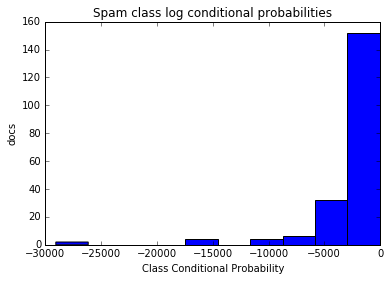

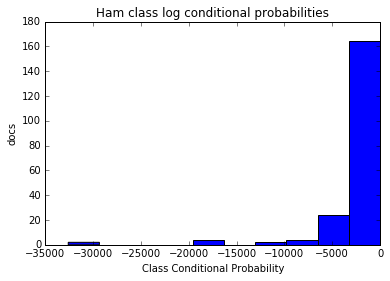

In [557]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_2_4():
    
    data=pd.read_csv("histogram24.tsv", sep='\t', header=None)
    columns=['p_spam','p_ham']
    data.columns=columns
     
    plt.hist(data['p_spam'])
    plt.xlabel("Class Conditional Probability")
    plt.ylabel("docs")
    plt.title("Spam class log conditional probabilities")
    plt.show()
    
    plt.hist(data['p_ham'])
    plt.xlabel("Class Conditional Probability")
    plt.ylabel("docs")
    plt.title("Ham class log conditional probabilities")
    plt.show()

run_2_4()


## HW2.5

Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassification error of learnt naive multinomial Bayesian Classifier on the training dataset

### HW2.5 Reducer #1

In [595]:
%%writefile reducer25.py
#!/usr/bin/python
## reducer.py
## Author: James Gray
## Description: reducer code for HW2.3

from __future__ import division
import sys
from math import log

# counters for words and documents - this will be used by reducer to calculate priors
ham_word_count =0
spam_word_count = 0
ham_doc_count = 0
spam_doc_count = 0

current_word = None
word = None
current_spam_count = 0
current_ham_count=0
current_count=0

prior_ham=0
prior_spam=0

words={} # dictionary to hold conditional probabilities

# process input from STDIN from mapper (word, spam_flag) OR (DOC.CLASS, spam_flag)
for line in sys.stdin:
    # remove leading and trailing whitespaces
    line = line.strip()
    # parse the mapper output into key, value
    cols = line.split('\t')
    word = cols[0]
    spam = cols[1]
    count = cols[2]
    
    # convert value strings into integers
    try: 
        spam = int(spam)
        count = int(count)
    except ValueError:
        # value failed casting so continue on
        continue
    
    # check to see if key-value is at the document level to calculate # of documents for each class     
    if word =='DOC.CLASS':
        if spam==0:
            # increment count of ham docs
            ham_doc_count+=1
        else:
            # increment count of spam docs
            spam_doc_count+=1
    
    # count number of word occurences based on Michael G. Noll algorithm
    if current_word == word:
        current_count+=count
        if spam==1:
            current_spam_count+=1
            spam_word_count+=1 # total words in spam documents
        elif spam==0:
            current_ham_count+=1
            ham_word_count+=1 # total words in ham documents
    else:
        if current_word and current_count >=3:  #add to dict if frequency >=3
            # write result to STDOUT
            # this will provide the occurences of the word in spam and ham classes
            #print(current_word+'\t'+str(current_spam_count)+'\t'+str(current_ham_count))
            # add word to dictionary
            words[current_word] = {'spam_count':current_spam_count, 'ham_count':current_ham_count}
    
        # set the current word
        current_word = word
        current_count= count
        if spam==1:
            current_spam_count=1
            current_ham_count=0
            spam_word_count+=1 # total words in spam documents
        elif spam==0:
            current_ham_count=1
            current_spam_count=0
            ham_word_count+=1 # total words in ham documents
            
# do not forget to output the last word if needed!
if current_word == word and current_count >=3:
    # emit word and # of occurences in spam \t # of occurences in ham
    #print(current_word+'\t'+ str(current_spam_count)+'\t'+str(current_ham_count))
    # add word to dictionary
    words[current_word] = {'spam_count':current_spam_count, 'ham_count':current_ham_count}

vocab_count = len(words)

# calculate conditional probabilities for each word with smoothing
for k,word in words.iteritems():
    # calculate and add to dictionary
    word['prob_spam'] = (word['spam_count']+1)/(spam_word_count+vocab_count)
    word['prob_ham'] = (word['ham_count']+1)/(ham_word_count+vocab_count)
    # emit key-value pair for conditional probs
    #print(k + str(word['prob_spam'] + str(word['prob_ham']))
    print k + '\t' + str(word['prob_spam']) + '\t' + str(word['prob_ham'])
    
# calculate and emit priors
prior_spam = spam_doc_count/(spam_doc_count + ham_doc_count)
prior_ham = ham_doc_count/(spam_doc_count + ham_doc_count)
print('%s\t%s\t%s') % ('*SPAMHAM.PRIOR', prior_spam, prior_ham)

Overwriting reducer25.py


### HW2.5 Mapper #2

In [596]:
%%writefile mapper25.py
#!/usr/bin/python
## mapper25.py
## Author: James Gray
## Description: 2nd mapper code for HW2.3

from __future__ import division
import sys
from math import log,exp
import re
import subprocess

# variables to calculate conditional probabilities
prob={} 
spam_email_count=0 # number of emails marked as spam
spam_word_count=0 # number of total (not unique) words in spam emails
ham_word_count=0 # number of total (not unique) words in ham emails
v_count = 0 # total number of words in the corpus vocabulary
doc_count = 0 # total number of documents in corpus
zero_prob_spam = 0
zero_prob_ham = 0

prior_spam = 0.0
prior_ham = 0.0

p_spam = 0.0
p_ham = 0.0

zero_prob_count = 0 # count how many times there were words not in the dictionary -> 0 probability
misclassify_count = 0 # count how many times the classifier to not classify to true class

WORD_RE = re.compile(r"[\w']+")

# load reducer output that contains 2 key-value pair types: 
# for word counts:  word \t #_of_occurences_in_spam \t #_of_occurences_in_ham
# for prior calcs:  SPAMHAM.PRIOR \t prior_spam \t prior_ham

# read mapper #1 output directly from HDFS
cat = subprocess.Popen(["hadoop", "fs", "-cat", "/user/graymatter/hw25_job1-output/part-00000"], stdout=subprocess.PIPE)
for line in cat.stdout:
    # remove leading and trailing whitespace
    line = line.strip()
    cols = line.split('\t') # parse the line to pull out key & values 
        
    # check to see if key-value pair is for priors
    if cols[0]=="*SPAMHAM.PRIOR":
        prior_spam = float(cols[1])
        prior_ham = float(cols[2])
        
    # if not priors then its conditional probs for each word
    else:   
        # added Tuesday -> changed reducer #1 to calc conditional probs; rebuild dict here
        word = cols[0]
        spam_cond_prob = float(cols[1])
        ham_cond_prob = float(cols[2])
        # populate dict
        prob[word] = {'prob_spam':spam_cond_prob, 'prob_ham':ham_cond_prob}
        
# calculate the vocabulary size
v_count = len(prob)

# iterate through each word and calculate the conditional probability without smoothing
#for k,word in words.iteritems():
    # calculate and add to dictionary
#    word['prob_spam'] = (word['spam_count']/(spam_word_count))
#    word['prob_ham'] = (word['ham_count']/(ham_word_count))
    
# we now have a dictionary of each word and their conditional probabilities for spam / ham
# we can now make predictions for each document in the corpus

# read in the Enron email corpus
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    cols = line.split('\t') # parse the line to pull out key & values
    true_class = int(cols[1])
    email_id = cols[0]
    #parse the subject and body fields from the line, and combine into one string
    subject_and_body=" ".join(cols[-2:])
    words_in_doc=re.findall(WORD_RE,subject_and_body) #create list of unique words in doc
    
    # calculate the log prob for priors
    p_spam=log(prior_spam)
    p_ham=log(prior_ham)
    
    # iterate through each word of the email subject and header
    for word in words_in_doc:
        # check to see if word has zero prob for the class and if so increment the counter
        
        try:
            p_spam+=log(float(prob[word]['prob_spam'])) # adds conditional probs to prior prob brought in above
        except ValueError:
            zero_prob_spam+=1 # log of 0 throws an error
        except KeyError: # word and conditional probability does not exist
            pass
        try:    
            p_ham+=log(float(prob[word]['prob_ham'])) 
        except ValueError:
            zero_prob_ham+=1
        except KeyError:
            pass
        
    # make the prediction
    if p_spam > p_ham:
        spam_pred = 1
    else:
        spam_pred = 0
    
    with open("histogram25.tsv", "a") as hist_file:
        hist_file.write('%f\t%f\n' % (p_spam, p_ham))
        
    # calculate the accuracy
    if spam_pred != true_class:
        misclassify_count+=1
    
    # send output to reducer
    print(email_id + '\t' + str(true_class) + '\t' + str(spam_pred))
    
           
# send number of zero probabilities to reducer
print("ZERO.PROB" + '\t' + str(zero_prob_spam) + '\t' + str(zero_prob_ham))

Overwriting mapper25.py


In [597]:
# set file priveleges to execute script

!chmod a+x reducer25.py
!chmod a+x mapper25.py

### HW2.5 Run Locally on UNIX

In [598]:
!cat enronemail_1h.txt | ./mapper.py |sort | ./reducer25.py > part-00000
!cat enronemail_1h.txt | ./mapper25.py | ./reducer2.py

16/05/28 23:14:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
zero_prob_spam 	2964
zero_prob_ham 	2376
misclass_rate 	0


In [599]:
# delete any existing files in the output directory
!hadoop fs -rm -r /user/graymatter/hw25_job1-output

# Run first MR job
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper.py,reducer25.py -mapper mapper.py -reducer reducer25.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw25_job1-output

16/05/28 23:15:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/28 23:15:35 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw25_job1-output
16/05/28 23:15:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/28 23:15:37 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/28 23:15:37 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/28 23:15:37 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/28 23:15:37 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/28 23:15:37 INFO mapreduce.JobSubmitter: number of splits:1
16/05/28 23:15:37 INFO mapreduce

In [600]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw25_job1-output/* 

16/05/28 23:15:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
limited	0.000492756479748	0.000309808538323
four	0.000295653887849	0.000247846830659
hate	0.000246378239874	6.19617076647e-05
looking	0.000246378239874	6.19617076647e-05
bailout	4.92756479748e-05	0.000557655368982
whatsoever	0.000197102591899	6.19617076647e-05
under	0.000492756479748	0.00092942561497
merchant	0.000197102591899	0.000185885122994
collaborate	4.92756479748e-05	0.000247846830659
risk	0.000197102591899	0.00291220026024
regional	4.92756479748e-05	0.000743540491976
every	0.000739134719622	6.19617076647e-05
we'll	0.000591307775697	6.19617076647e-05
withers	4.92756479748e-05	0.000309808538323
companies	0.000295653887849	0.000247846830659
wednesday	4.92756479748e-05	0.000433731953653
deadline	0.000246378239874	0.000185885122994
force	0.000246378239874	0.000123923415329
direct	9.85512959495e-05	0.000247846830659
tires	0.00019710259189

In [604]:
# Run 2nd MR Job

!hadoop fs -rm -r /user/graymatter/hw25_job2-output

!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-files mapper25.py,reducer2.py -mapper mapper25.py -reducer reducer2.py \
-input /user/graymatter/enronemail_1h.txt -output /user/graymatter/hw25_job2-output

16/05/28 23:20:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/28 23:20:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/graymatter/hw25_job2-output
16/05/28 23:20:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/28 23:20:54 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/05/28 23:20:54 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/05/28 23:20:54 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/05/28 23:20:54 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/28 23:20:54 INFO mapreduce.JobSubmitter: number of splits:1
16/05/28 23:20:54 INFO mapreduce

In [605]:
#print("the number of occurences of the word assistance")
!hadoop fs -cat /user/graymatter/hw25_job2-output/* 

16/05/28 23:21:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
zero_prob_spam 	0
zero_prob_ham 	0
misclass_rate 	0.02


This scenario produced no zero probabilities due to smoothing and very small increase (0.02) misclassification rate.

## HW2.6

Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

In this exercise, please complete the following:

— Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
— Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

In [549]:
import re
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

### HW2.6 Step 1 - Data read and cleaning for SK Learn Multinomial NB Algorithm

In [550]:
with open('enronemail_1h.txt','rb') as f:
    data=pd.read_csv(f, sep='\t', header=None, na_filter=True)

    # add column names to DataFrame
df_columns = ["id", "spamflag", "subject", "body"]
data.columns = df_columns
# concatenate subject and body to create a text string to be evaluated by classifier
data['subject_body'] = data["subject"] + data["body"]
dataClean = data.dropna()
dataClean

,id,spamflag,subject,body,subject_body
1,0001.1999-12-10.kaminski,0,re: rankings,thank you.,re: rankings thank you.
2,0001.2000-01-17.beck,0,leadership development pilot,"sally: what timing, ask and you shall receiv...",leadership development pilot sally: what tim...
4,0001.2001-02-07.kitchen,0,key hr issues going forward,a) year end reviews-report needs generating l...,key hr issues going forward a) year end revie...
5,0001.2001-04-02.williams,0,re: quasi,"good morning, i'd love to go get some coffee...","re: quasi good morning, i'd love to go get s..."
6,0002.1999-12-13.farmer,0,"vastar resources, inc.","gary, production from the high island larger ...","vastar resources, inc. gary, production from ..."
7,0002.2001-02-07.kitchen,0,congrats!,contratulations on the execution of the centr...,congrats! contratulations on the execution of...
8,0002.2001-05-25.SA_and_HP,1,fw: this is the solution i mentioned lsc,"oo thank you, your email address was obtain...",fw: this is the solution i mentioned lsc oo ...
9,0002.2003-12-18.GP,1,adv: space saving computer to replace that bi...,revolutionary!!! full featured!!! space savi...,adv: space saving computer to replace that bi...
10,0002.2004-08-01.BG,1,advs,"greetings, i am benedicta lindiwe hendricks ...","advs greetings, i am benedicta lindiwe hendr..."
11,0003.1999-12-10.kaminski,0,re: visit to enron,"vince, dec. 29 at 9:00 will be fine. i have ...","re: visit to enron vince, dec. 29 at 9:00 wi..."


### HW2.6 Step 2 - Create text features using CountVectorizer

The [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts. Here it will process the 'subject_body' field of the DataFrame to create a vector of words and their counts. The fit_transform method creates a document-term matrix on the number of times a specific word (feature) appears in the document.  In this scenario we have 100 or less records given that we filtered out the records where an "NA" appears in the row.

In [551]:
# create matrix for a single word, convert to lowercase first, filter words with document frequency < 3
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
# create a document-term matrix 
vocabulary = vectorizer.fit_transform(dataClean['subject_body'])
print (vocabulary)

  (0, 3886)	1
  (0, 3871)	1
  (0, 4731)	1
  (0, 5255)	1
  (1, 4731)	1
  (1, 5255)	5
  (1, 2838)	7
  (1, 1524)	3
  (1, 3606)	6
  (1, 4167)	1
  (1, 5136)	1
  (1, 4785)	1
  (1, 625)	1
  (1, 526)	11
  (1, 4301)	1
  (1, 3914)	2
  (1, 619)	3
  (1, 3552)	1
  (1, 3448)	2
  (1, 1581)	1
  (1, 2910)	3
  (1, 785)	3
  (1, 2651)	4
  (1, 518)	2
  (1, 4967)	2
  :	:
  (93, 2883)	1
  (93, 1233)	1
  (93, 4854)	2
  (93, 565)	1
  (93, 3824)	1
  (93, 3678)	1
  (93, 607)	1
  (93, 4633)	1
  (93, 3840)	1
  (93, 1652)	1
  (93, 4717)	1
  (93, 2081)	1
  (93, 2633)	1
  (93, 3553)	1
  (93, 1261)	1
  (93, 395)	1
  (93, 1190)	1
  (93, 4506)	1
  (93, 1399)	1
  (93, 382)	1
  (93, 729)	1
  (93, 1392)	1
  (93, 103)	1
  (93, 271)	1
  (93, 280)	1


### HW2.6 Step 3 - Run SK Learn Multinomial Naive Bayer Classifier

The [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) algorithm uses word counts for classification.

In [552]:
multiNB = MultinomialNB()
# fit the model to the training data using document-term matrix and class of whether SPAM or not
multiNB.fit(vocabulary, dataClean['spamflag'])
# make predictions using the training data
mnbclf_results = multiNB.predict(vocabulary)
# calculate accuracy using metrics libary
from sklearn.metrics import accuracy_score
print ("SK Learn Multinomial NB training error: " + str(1-accuracy_score(dataClean['spamflag'],mnbclf_results)))

SK Learn Multinomial NB training error: 0.0


### HW2.6 Step 4 - Summary of Error Results and Conclusions

### HW2.6 Summary of Error Results and Conclusions

This section compares and contrasts errors produces by map-reduce and scikit-learn


| Model                                                                      | Training Error |
|----------------------------------------------------------------------------|----------------|
| Multinomial NB, Scikit-Learn Implementation                                | 0.00            |
| Multinomial NB HW2.5, MapReduce implementation                                   | 0.02           |

#### Analysis of Multinomial Naive Bayes models (MapReduce and scikit-learn)
The MapReduce multinomial Naive Bayes model had a slightly hihgher training error when compared to the scikit-learn implementation.  We know from homework #1 that scikit-learn used Laplace smoothing by default which may explain the small difference in error.

## HW 2.6.1 OPTIONAL (note this exercise is a stretch HW and optional)


—  Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error 
-  Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain. 

Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.


## HW2.7 OPTIONAL (note this exercise is a stretch HW and optional)

The Enron SPAM data in the following folder enron1-Training-Data-RAW is in raw text form (with subfolders for SPAM and HAM that contain raw email messages in the following form:

--- Line 1 contains the subject
--- The remaining lines contain the body of the email message.

In Python write a script to produce a TSV file called train-Enron-1.txt that has a similar format as the enronemail_1h.txt that you have been using so far. Please pay attend to funky characters and tabs. Check your resulting formated email data in Excel and in Python (e.g., count up the number of fields in each row; the number of SPAM mails and the number of HAM emails). Does each row correspond to an email record with four values? Note: use "NA" to denote empty field values.




## HW2.8 OPTIONAL
Using Hadoop Map-Reduce write job(s) to perform the following:
 -- Train a multinomial Naive Bayes Classifier with Laplace plus one smoothing using the data extracted in HW2.7 (i.e., train-Enron-1.txt). Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Drop tokens with a frequency of less than three (3).
 -- Test the learnt classifier using enronemail_1h.txt and report the misclassification error rate. Remember to use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). How do we treat tokens in the test set that do not appear in the training set?


## HW2.8.1 OPTIONAL

—  Run  both the Multinomial Naive Bayes and the Bernoulli Naive Bayes algorithms from SciKit-Learn (using default settings) over the same training data used in HW2.8 and report the misclassification error on both the training set and the testing set
- Prepare a table to present your results, where rows correspond to approach used (SciKit-Learn Multinomial NB; SciKit-Learn Bernouili NB; Your Hadoop implementation)  and the columns presents the training misclassification error, and the misclassification error on the test data set
-  Discuss the performance differences in terms of misclassification error rates over the test and training datasets by the different implementations. Which approch (Bernouili versus Multinomial) would you recommend for SPAM detection? Justify your selection.


